# Data Loading

### Loading the Exoplanet training data

The exoplanet training data has already been separated into X_train, X_test, y_train, y_test. 

We will use it for the training


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
X_train = np.loadtxt('middle_data/X_train.txt', delimiter=' ')
X_test  = np.loadtxt('middle_data/X_test.txt', delimiter=' ')

Y_train = np.loadtxt('middle_data/Y_train.txt', delimiter=' ')
Y_test  = np.loadtxt('middle_data/Y_test.txt', delimiter=' ')

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (2000, 37)
X_test shape: (2000, 37)
Y_train shape: (2000,)
Y_test shape: (2000,)


In [6]:
print(type(X_train))

<class 'numpy.ndarray'>


### 1. Data pre-processing 

In this step, we will perform normalization of the X dataset, and label y in binary terms

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Dimensionality reduction
pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Normalize data to the range [-1, 1] (use the training set to fit the scaler)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure labels are binary (if not already binary)
Y_train = (Y_train > np.median(Y_train)).astype(int)
Y_test = (Y_test > np.median(Y_test)).astype(int)

print(f"X_train shape after selection: {X_train.shape}")
print(f"X_test shape after selection: {X_test.shape}")

X_train shape after selection: (2000, 2)
X_test shape after selection: (2000, 2)


In [16]:
Y_train.shape

(2000,)

# Building MLP model

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Hyperparameters
batch_size = 32
learning_rate = 0.01
epochs = 30
num_classes = 2
input_size = 2

In [28]:
# Building dataset 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)  
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)  
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [25]:
# Creating MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 512)
        self.linear3 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x


In [37]:
# Creating Training Loop
# Referenced from: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_one_epoch(model, criterion, optimizer, trainloader):
    running_loss = 0.0

    for inputs, labels in tqdm(trainloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(trainloader)
    return train_loss

def evaluate_loss(model, criterion, testloader, device):
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    avg_loss = test_loss / len(testloader)
    return avg_loss

def evaluate_accuracy(model, testloader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

def train(model, optimizer, criterion, trainloader, testloader, epochs, device):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    best_loss = float('inf')

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(torch.device(device))

    for epoch in range(epochs):
        print(f'EPOCH {epoch+1}/{epochs}:', end=" ")

        model.train()

        train_loss = train_one_epoch(model, criterion, optimizer, trainloader)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss}")

        model.eval()

        train_accuracy = evaluate_accuracy(model, trainloader, device)
        train_accuracies.append(train_accuracy)
        print(f"Train Accuracy: {train_accuracy:.2f}%")

        test_loss = evaluate_loss(model, criterion, testloader, device)
        test_losses.append(test_loss)
        print(f"Test Loss: {test_loss}")

        test_accuracy = evaluate_accuracy(model, testloader, device)
        test_accuracies.append(test_accuracy)
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        # Save best model
        if test_loss < best_loss:
          best_loss = test_loss
          model_path = 'mlp_model_{}'.format(epoch)
          torch.save(model.state_dict(), model_path)

    return train_losses, test_losses, train_accuracies, test_accuracies


In [38]:
# Training MLP Model
mlp_model = MLPModel(input_size, num_classes)

# Print the model architecture
print(mlp_model)

# Define optimizers for the models
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)

criterion = torch.nn.CrossEntropyLoss()
# Train the NLP model
train_losses, test_losses, train_accuracies, test_accuracies = train(mlp_model, optimizer, criterion, train_loader, test_loader, epochs, device)
torch.save(mlp_model.state_dict(), 'mlp_model_final_weights.pth')
torch.save((train_losses, test_losses), 'mlp_model_final_losses.pt')

MLPModel(
  (linear1): Linear(in_features=2, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=2, bias=True)
  (relu): ReLU()
)
EPOCH 1/30: 

  0%|          | 0/63 [00:00<?, ?it/s]

100%|██████████| 63/63 [00:14<00:00,  4.32it/s]


Train Loss: 0.6892663968933953
Train Accuracy: 50.00%
Test Loss: 0.683120019852169
Test Accuracy: 49.90%
EPOCH 2/30: 

100%|██████████| 63/63 [00:16<00:00,  3.76it/s]


Train Loss: 0.6770820939351642
Train Accuracy: 65.80%
Test Loss: 0.6727248070731996
Test Accuracy: 65.15%
EPOCH 3/30: 

100%|██████████| 63/63 [00:17<00:00,  3.61it/s]


Train Loss: 0.6672311737423852
Train Accuracy: 49.75%
Test Loss: 0.6678901380962796
Test Accuracy: 49.85%
EPOCH 4/30: 

100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Train Loss: 0.6574553241805424
Train Accuracy: 65.05%
Test Loss: 0.6577268744271899
Test Accuracy: 64.10%
EPOCH 5/30: 

100%|██████████| 63/63 [00:18<00:00,  3.39it/s]


Train Loss: 0.6515284464472816
Train Accuracy: 62.80%
Test Loss: 0.6524526987757001
Test Accuracy: 61.15%
EPOCH 6/30: 

100%|██████████| 63/63 [00:15<00:00,  3.97it/s]


Train Loss: 0.643638981713189
Train Accuracy: 65.75%
Test Loss: 0.647521902644445
Test Accuracy: 65.15%
EPOCH 7/30: 

100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


Train Loss: 0.6398864369543772
Train Accuracy: 65.20%
Test Loss: 0.642773293313526
Test Accuracy: 64.25%
EPOCH 8/30: 

100%|██████████| 63/63 [00:19<00:00,  3.16it/s]


Train Loss: 0.6372233430544535
Train Accuracy: 63.50%
Test Loss: 0.6396290063858032
Test Accuracy: 62.20%
EPOCH 9/30: 

100%|██████████| 63/63 [00:20<00:00,  3.15it/s]


Train Loss: 0.6340736216968961
Train Accuracy: 49.70%
Test Loss: 0.644984349371895
Test Accuracy: 49.60%
EPOCH 10/30: 

100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


Train Loss: 0.6286553494513981
Train Accuracy: 64.05%
Test Loss: 0.6337080039675274
Test Accuracy: 62.65%
EPOCH 11/30: 

100%|██████████| 63/63 [00:17<00:00,  3.58it/s]


Train Loss: 0.6282068897807409
Train Accuracy: 65.70%
Test Loss: 0.6308859908391559
Test Accuracy: 64.65%
EPOCH 12/30: 

100%|██████████| 63/63 [00:19<00:00,  3.25it/s]


Train Loss: 0.6238498016009255
Train Accuracy: 61.25%
Test Loss: 0.6615918297616262
Test Accuracy: 59.90%
EPOCH 13/30: 

100%|██████████| 63/63 [00:17<00:00,  3.55it/s]


Train Loss: 0.6242056659289769
Train Accuracy: 49.60%
Test Loss: 0.6365559072721572
Test Accuracy: 49.50%
EPOCH 14/30: 

100%|██████████| 63/63 [00:16<00:00,  3.79it/s]


Train Loss: 0.6218891503318907
Train Accuracy: 64.60%
Test Loss: 0.6245137121942308
Test Accuracy: 63.60%
EPOCH 15/30: 

100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Train Loss: 0.6176655406043643
Train Accuracy: 65.90%
Test Loss: 0.6241905547323681
Test Accuracy: 65.15%
EPOCH 16/30: 

100%|██████████| 63/63 [00:18<00:00,  3.48it/s]


Train Loss: 0.6164670491975451
Train Accuracy: 63.85%
Test Loss: 0.6253948372507853
Test Accuracy: 62.65%
EPOCH 17/30: 

100%|██████████| 63/63 [00:19<00:00,  3.23it/s]


Train Loss: 0.6136144711857751
Train Accuracy: 49.60%
Test Loss: 0.6317189610193646
Test Accuracy: 49.55%
EPOCH 18/30: 

100%|██████████| 63/63 [00:19<00:00,  3.20it/s]


Train Loss: 0.6179773921058291
Train Accuracy: 65.65%
Test Loss: 0.6186369014164758
Test Accuracy: 64.65%
EPOCH 19/30: 

100%|██████████| 63/63 [00:20<00:00,  3.06it/s]


Train Loss: 0.6114402517439828
Train Accuracy: 66.00%
Test Loss: 0.6186287299035087
Test Accuracy: 65.70%
EPOCH 20/30: 

100%|██████████| 63/63 [00:18<00:00,  3.44it/s]


Train Loss: 0.6108434545615363
Train Accuracy: 65.75%
Test Loss: 0.6167308470559498
Test Accuracy: 65.15%
EPOCH 21/30: 

100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


Train Loss: 0.6134894178027198
Train Accuracy: 48.25%
Test Loss: 0.6229594614770677
Test Accuracy: 48.45%
EPOCH 22/30: 

100%|██████████| 63/63 [00:27<00:00,  2.33it/s]


Train Loss: 0.6119558271907625
Train Accuracy: 63.55%
Test Loss: 0.6294203542527699
Test Accuracy: 62.30%
EPOCH 23/30: 

100%|██████████| 63/63 [00:22<00:00,  2.74it/s]


Train Loss: 0.6093806643334646
Train Accuracy: 63.05%
Test Loss: 0.6441516743765937
Test Accuracy: 61.50%
EPOCH 24/30: 

100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


Train Loss: 0.6117105332631914
Train Accuracy: 65.90%
Test Loss: 0.6145699468870012
Test Accuracy: 65.70%
EPOCH 25/30: 

100%|██████████| 63/63 [00:18<00:00,  3.41it/s]


Train Loss: 0.6115244357358842
Train Accuracy: 64.40%
Test Loss: 0.6171418409498911
Test Accuracy: 63.35%
EPOCH 26/30: 

100%|██████████| 63/63 [00:22<00:00,  2.76it/s]


Train Loss: 0.6086036042561607
Train Accuracy: 49.80%
Test Loss: 0.6533726482164293
Test Accuracy: 49.90%
EPOCH 27/30: 

100%|██████████| 63/63 [00:17<00:00,  3.52it/s]


Train Loss: 0.6079804594554599
Train Accuracy: 66.55%
Test Loss: 0.6139504341852098
Test Accuracy: 66.20%
EPOCH 28/30: 

100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


Train Loss: 0.6037688085011074
Train Accuracy: 66.10%
Test Loss: 0.612057394924618
Test Accuracy: 66.05%
EPOCH 29/30: 

100%|██████████| 63/63 [00:21<00:00,  2.90it/s]


Train Loss: 0.6061613029903836
Train Accuracy: 65.80%
Test Loss: 0.609187106291453
Test Accuracy: 65.25%
EPOCH 30/30: 

100%|██████████| 63/63 [00:18<00:00,  3.43it/s]


Train Loss: 0.6019011452084496
Train Accuracy: 49.80%
Test Loss: 0.6293582348596483
Test Accuracy: 49.70%


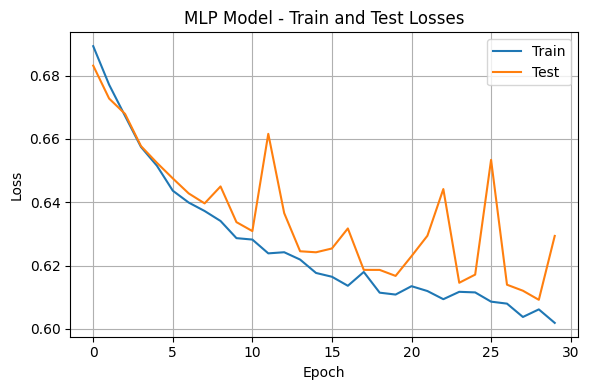

In [41]:
# Evaluating MLP Model
## Plot loss graph
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"MLP Model - Train and Test Losses")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()



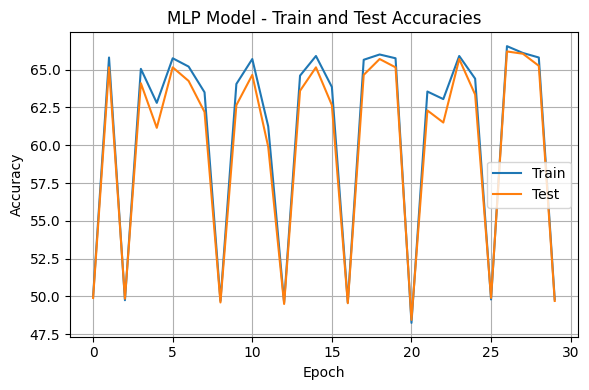

In [42]:
## Plot accuracy graph
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"MLP Model - Train and Test Accuracies")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()